## <p style="text-align:center" color="red"><span style="color:red">Language identifier with Support Vector Machine</span></p>


<table align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/labrijisaad/Language-Identifier-SVM"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

- 🎯 In this notebook, I tried to write a script capable of identifying the language used in a text. 
- 🛠️ The supported languages are:  **`Swahili`**, **`Wolof`**, **`French`**, **`English`**, **`Arabic`** and **`Dyula`**.
> The code in this notebook can easily be modified to add or modify the languages you want to detect: if you want to add other languages, just add a training dataset on the targeted languages, this dataset can be found by example on [HuggingFace Datesets](https://huggingface.co/datasets?sort=downloads).
- 📫 Feel free to contact me if anything is wrong or if anything needs to be changed 😎!  **labrijisaad@gmail.com**

### Importing the necessary libraries

In [1]:
%%capture
!pip install datasets # to import the Hugging Face dataset (community dataset containing labeled phrases)

In [2]:
%%capture

import codecs
import seaborn as sns 
import re
import glob
import unidecode
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from tqdm import tqdm
from sklearn import svm
from datetime import datetime
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
tqdm.pandas()

from datasets import load_dataset

### Importing the data

In [3]:
dataset = load_dataset("papluca/language-identification") # Dataset downloaded from huggingface
df_languages = pd.DataFrame.from_dict(dataset['train'])
df_languages.sample(3)

Using custom data configuration papluca--language-identification-088edc04c6573c74
Reusing dataset csv (C:\Users\SAAD\.cache\huggingface\datasets\papluca___csv\papluca--language-identification-088edc04c6573c74\0.0.0\652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/3 [00:00<?, ?it/s]

,labels,text
58155,ru,"Боюсь , что так , сказал Мистер Картер серьезно ."
46273,fr,Je vous ferais part de mon commentaire lorsque...
42982,ru,И еще в 1994 году правительство тюрьму в тюрьм...


In [4]:
languages_file = pd.read_csv('corpus_id.csv') # Dataset that contains labelled sentences from :Wolof, Swahili, English, Arabic and French 
languages_file.sample(3)

,sentence,lang
59218,baadhi ya wanachama wa simba na wadau wa mpira...,swahili
47485,"the Plateau of the Cumberland, and here the la...",english
25226,katika mchezo huo wa ligi kuu bara yanga ilish...,swahili


In [5]:
dyula_list = [] 
with codecs.open('bible_dyula.txt', encoding='utf-8') as file:
    for text in file:
        dyula_list.append(text)

df_dyula = pd.DataFrame (dyula_list, columns = ['sentence'])
df_dyula.sample(3) # Dataset containing Dyula sentences extracted with selenium from the bible

,sentence
40146,"Ala ka kɔgɔji danfɛn barakamanw dan, ani jiraf..."
54704,"Ala ka o furancɛ wele ko «sankolo». Ayiwa, su ..."
37492,"Minw bɛ jija koɲuman na, ka tandori ni bonya n..."


### Data exploration analysis

In [6]:
%%capture

# Collecting Arabic phrases from huggingface dataset.
df_ar = df_languages[df_languages.labels == "ar"]
df_ar.rename(columns = {'labels':'lang', 'text':'sentence'}, inplace = True)
df_ar["lang"] = "arabic"

# Taking a random sample of 14000 sentences (from the english Hugging face datset) to properly balance our training dataset.
df_en = df_languages[df_languages.labels == "en"].sample(1000)
df_en.rename(columns = {'labels':'lang', 'text':'sentence'}, inplace = True)
df_en["lang"] = "english"
df_en

In [7]:
df_dyula["sentence"] = df_dyula["sentence"].str.replace("\n"," ") 
df_dyula["sentence"] = df_dyula["sentence"].str.replace("\t"," ") 
df_dyula["sentence"] = df_dyula["sentence"].str.replace("\r"," ") 
df_dyula['lang'] = 'dyula'

# Taking a random sample of 14000 sentences (from the Dyula datset) to properly balance our training dataset.
df_dyula = df_dyula.sample(n = 14000) 
df_dyula

,sentence,lang
41416,"Su kora, ka o dugu gbɛ. O kɛra lon naaninan ye.",dyula
8316,"Kɛrɛkɛden kanbelen minw tun bɛ Yohabu kɔ, olug...",dyula
11749,"O bɛɛ tagara ɲɔgɔn lajɛn Zeruzalɛmu, Asa ta ma...",dyula
40008,"Ne ko: aw minw b’a fɛ ka sariya* sira tagama, ...",dyula
47181,"Dugukolo bɛganw bɛɛ, ani kɔnɔw bɛɛ, ani fɛnɲan...",dyula
...,...,...
37958,"Ala ka baraka don o ra, ko o ye woro, ka caya ...",dyula
51673,"A ka kelen sigi terefɛwagati kunna, ka kelen s...",dyula
22119,,dyula
9478,"Ala ka o furancɛ kɛ. Ji minw bɛ san fɛ, ani ji...",dyula


In [8]:
languages_file = pd.concat([languages_file, df_dyula, df_ar, df_en]) 
languages_file

,sentence,lang
0,mu ne dina fi jaar buy dellu,wolof
1,mimi ningekuwa naipenda yanga si ningekuwa nac...,swahili
2,Pencil skirts are nice until you have to go up...,english
3,"#Kingsport , TN #Transportation #Job: Rolloff ...",english
4,daan sa doole,wolof
...,...,...
2023,just ok. inner plastic curtain keeps falling o...,english
49318,Great for daily devotions!,english
46698,This is not the Jason shampoo with MSM. I look...,english
33705,"It charges extremely slowly for some reason, a...",english


- **83195**  is the number of records in our dataset.
- **2** is the number of columns.

In [9]:
languages_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83195 entries, 0 to 42648
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  83195 non-null  object
 1   lang      83195 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB


In [10]:
languages_file.isna().sum()

sentence    0
lang        0
dtype: int64

- Good news so far, there are no missing values in our dataframe.

In [11]:
# Dealing with capitalized values :
languages_file['sentence'] = languages_file['sentence'].str.lower()

# Dealing with trailing spaces :
languages_file['sentence'] = languages_file['sentence'].str.strip()

In [12]:
# Dealing with empty sentences :
languages_file['sentence'].replace('', np.nan, inplace=True)
languages_file.dropna(subset=['sentence'], inplace=True)

# Dealing with the ponctuation :
def remove_ponctuation(text):
    return re.sub(r'[^\w\s]', '', text)

languages_file['sentence'] = languages_file['sentence'].apply(lambda x: remove_ponctuation(x))

> **`Here is the dataset that we are going to use to train our language identification model:`**

In [13]:
languages_file

,sentence,lang
0,mu ne dina fi jaar buy dellu,wolof
1,mimi ningekuwa naipenda yanga si ningekuwa nac...,swahili
2,pencil skirts are nice until you have to go up...,english
3,kingsport tn transportation job rolloff drive...,english
4,daan sa doole,wolof
...,...,...
2023,just ok inner plastic curtain keeps falling of...,english
49318,great for daily devotions,english
46698,this is not the jason shampoo with msm i looke...,english
33705,it charges extremely slowly for some reason al...,english


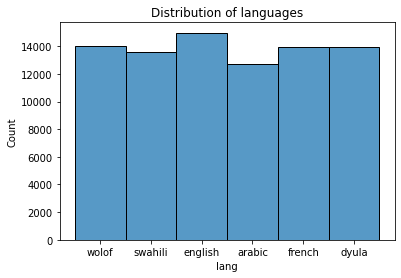

In [14]:
# Visualize the distribution of the languages column :
sns.histplot(languages_file['lang'])
plt.title('Distribution of languages')
plt.show()

In [15]:
languages_file.groupby('lang').count()

,sentence
lang,
arabic,12700
dyula,13929
english,14974
french,13928
swahili,13569
wolof,14024


> **`Our dataset is quite balanced and has enough data, normally we expect good results after training the model`**

In [16]:
languages_file

,sentence,lang
0,mu ne dina fi jaar buy dellu,wolof
1,mimi ningekuwa naipenda yanga si ningekuwa nac...,swahili
2,pencil skirts are nice until you have to go up...,english
3,kingsport tn transportation job rolloff drive...,english
4,daan sa doole,wolof
...,...,...
2023,just ok inner plastic curtain keeps falling of...,english
49318,great for daily devotions,english
46698,this is not the jason shampoo with msm i looke...,english
33705,it charges extremely slowly for some reason al...,english


- The lang column is divided into 5 languages: **``swahili``**, **``wolof``**, **``french``**, **``english``**, **``arabic``** and **``dyula``**.

In [17]:
# WORD-COUNT
dataframe = languages_file.copy(deep=True)
dataframe['sentence']= dataframe['sentence'].apply(lambda x: len(str(x).split()))

dict_languages_wordcount = {}
languages_names = list(dataframe.lang.unique())

for language in languages_names:
    dict_languages_wordcount[language] = dataframe[dataframe['lang'].str.contains(language)].sentence.mean()

In [18]:
for key, value in dict_languages_wordcount.items():
    print(key, ' : ', value)

wolof  :  6.573302909298346
swahili  :  25.032426855332005
english  :  10.996260184319487
arabic  :  12.337322834645668
french  :  13.728388856978748
dyula  :  27.564074951539954


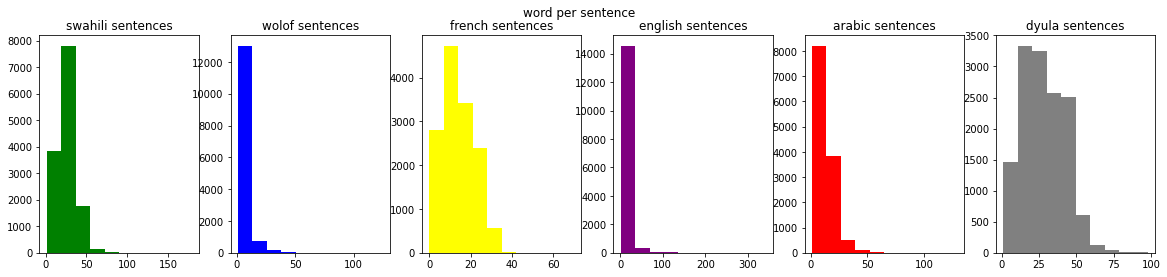

In [19]:
# PLOTTING WORD-COUNT
fig,(ax1, ax2, ax3, ax4, ax5, ax6)=plt.subplots(1,6,figsize=(20,4))

swahili_words = dataframe[dataframe['lang'].str.contains("swahili")].sentence
ax1.hist(swahili_words,color='green')
ax1.set_title('swahili sentences')


wolof_words = dataframe[dataframe['lang'].str.contains("wolof")].sentence
ax2.hist(wolof_words,color='blue')
ax2.set_title('wolof sentences')


french_words = dataframe[dataframe['lang'].str.contains("french")].sentence
ax3.hist(french_words,color='yellow')
ax3.set_title('french sentences')


english_words = dataframe[dataframe['lang'].str.contains("english")].sentence
ax4.hist(english_words,color='purple')
ax4.set_title('english sentences')


shikomori_words = dataframe[dataframe['lang'].str.contains("arabic")].sentence
ax5.hist(shikomori_words,color='red')
ax5.set_title('arabic sentences')

shikomori_words = dataframe[dataframe['lang'].str.contains("dyula")].sentence
ax6.hist(shikomori_words,color='gray')
ax6.set_title('dyula sentences')


fig.suptitle('word per sentence')
plt.show()

- Below we can see a quick comparison of the average number of words in a sentence of each language in our dataset.
- In our case, the most wordy language is **``dyula``** and the less one is **``wolof``**

### Model training: **`SVM classifier with TfidfVectorizer`**

#### Importing libraries needed for model training

In [20]:
import time
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from yaspin import yaspin 

#### Quick overview of the dataset we use for training the model

In [21]:
languages_file

,sentence,lang
0,mu ne dina fi jaar buy dellu,wolof
1,mimi ningekuwa naipenda yanga si ningekuwa nac...,swahili
2,pencil skirts are nice until you have to go up...,english
3,kingsport tn transportation job rolloff drive...,english
4,daan sa doole,wolof
...,...,...
2023,just ok inner plastic curtain keeps falling of...,english
49318,great for daily devotions,english
46698,this is not the jason shampoo with msm i looke...,english
33705,it charges extremely slowly for some reason al...,english


#### Data separation
> Because we are going to export our model we are going to use 95% of the data on traing and the rest for the test, i've already tested the model on 20% of the data and still got good results.

In [22]:
# Separating the 95% data for training data and 10% for testing data
X = languages_file.sentence
y = languages_file.lang

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=8888) 

#### Feature Vectorizing

In [23]:
# Fit the TF-IDF Vectorizer :
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

print('No. of feature_words: ', len(vectorizer.get_feature_names()))

No. of feature_words:  18121


C:\Users\SAAD\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### Performing classification

In [24]:
# Perform classification with SVM, kernel=linear
with yaspin(text="elapsed time", timer=True) as sp:
    classifier_linear = svm.SVC(kernel='linear', probability=True)
    t0 = time.time()
    classifier_linear.fit(train_vectors, y_train)
    t1 = time.time()
    prediction_linear = classifier_linear.predict(test_vectors)
    t2 = time.time()

0m elapsed time (0:07:08.91)

In [25]:
time_linear_train = t1-t0 # The time needed to train our linear classifier
time_linear_predict = t2-t1 # The time needed to predict with our trained linear classifier

print("Training time: {:.2f}s; Prediction time: {:.2f}s".format(time_linear_train, time_linear_predict))

Training time: 426.20s; Prediction time: 2.72s


#### Model testing 

In [26]:
import random as rd

In [27]:
report = classification_report(y_test, prediction_linear, output_dict=True)

print('wolof precision: {:.2f}%'.format(report['wolof']["precision"]*100))
print('french precision: {:.2f}%'.format(report['french']["precision"]*100))
print('swahili precision: {:.2f}%'.format(report['swahili']["precision"]*100))
print('english precision: {:.2f}%'.format(report['english']["precision"]*100))
print('arabic precision: {:.2f}%'.format(report['arabic']["precision"]*100))
print('dyula precision: {:.2f}%'.format(report['dyula']["precision"]*100))

print("\n")
print('wolof: ', report['wolof'])
print('french: ', report['french'])
print('swahili: ', report['swahili'])
print('english: ', report['english'])
print('arabic: ', report['arabic'])
print('dyula: ', report['dyula'])

wolof precision: 99.56%
french precision: 99.71%
swahili precision: 100.00%
english precision: 96.83%
arabic precision: 93.63%
dyula precision: 100.00%


wolof:  {'precision': 0.9956011730205279, 'recall': 0.9883551673944687, 'f1-score': 0.9919649379108838, 'support': 687}
french:  {'precision': 0.9971264367816092, 'recall': 0.9788434414668548, 'f1-score': 0.9879003558718862, 'support': 709}
swahili:  {'precision': 1.0, 'recall': 0.9849108367626886, 'f1-score': 0.9923980649619903, 'support': 729}
english:  {'precision': 0.9683195592286501, 'recall': 0.9736842105263158, 'f1-score': 0.9709944751381215, 'support': 722}
arabic:  {'precision': 0.9363354037267081, 'recall': 0.9741518578352181, 'f1-score': 0.9548693586698337, 'support': 619}
dyula:  {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 691}


In [28]:
# Defining a function to simplify the prediction process
def predict_language(text):
    serie = pd.Series(text)
    vector = vectorizer.transform(serie)
    return classifier_linear.predict(vector)[0]

In [29]:
random_number = rd.randint(0, len(languages_file)+1) # Picking a random sentence from the dataset
text = languages_file.sentence[random_number]
language = languages_file.lang[random_number]

print(text)
print("\n -> LABELED LANGUAGE: " + language)
print("-> PREDICTED LANGUAGE: " + predict_language(text))

mu dem ci ñaari xale yu góor yi ni leen ñaari xale yu góor yi du ngéen ma fetalal yëkku kuuy yëkku kuuy dee ma luqi bët bi diw ko asamaan asamaan taw wereyaan sax xar lekk ko dee mool ngemboo der ba dindil ma saa wujj wi ci biir déeg bi ba ma woli soq sa déegu jonn

 -> LABELED LANGUAGE: wolof
-> PREDICTED LANGUAGE: wolof


#### Saving the model

In [30]:
import pickle

pickle.dump(classifier_linear, open('model/SVM_model_language_identifier.pkl', 'wb')) # saving the model
with open('model/SVM_vectorizer.pk', 'wb') as fin: # saving the vectorizer
    pickle.dump(vectorizer, fin)
exit()

#### Loading the model

##### meth 1
> via model and vectorizer import

In [31]:
import pickle
import pandas as pd

SVM_model = pickle.load(open('model/SVM_model_language_identifier.pkl', 'rb'))
SVM_vectorizer = pickle.load(open("model/SVM_vectorizer.pk","rb"))


def predict_language(text):
    serie = pd.Series(text)
    vector = SVM_vectorizer.transform(serie)
    return str(SVM_model.predict(vector)[0])

In [32]:
text = "Na nga def ?" 
print(predict_language(text))

wolof


##### meth 2
> by calling a python script that does all the work for us

In [33]:
text = "I'm not really into the birthday thing honestly but I admit this was a really chill"
var = !python model/language_identifier.py $text 
print(var[-1])

english


> - 🙌 Notebook made by [@labriji_saad](https://github.com/labrijisaad)
> - 🔗 Linledin [@labriji_saad](https://www.linkedin.com/in/labrijisaad/)